In [22]:
import numpy as np
import pandas as pd
import polars as pl
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pathlib
from pathlib import Path

directory_raw = str(Path.cwd().parent) + '/data_raw/'

directory_processed = str(Path.cwd().parent) + '/data/'
print(directory_raw)
print(directory_processed)

/Users/brentondickerson/git/breathe/data_raw/
/Users/brentondickerson/git/breathe/data/


In [23]:
def read_data(folder, file_name):
    data= pl.from_pandas(pd.read_csv(
        directory_processed + f"/{folder}/{file_name}", delimiter=","
    ))
    return data

def save_data(data, file_name):
    data.write_csv(directory_processed + file_name + ".csv")
    print(f"{file_name} has been saved at {directory_processed}{file_name}.")

In [40]:
# Calculate the income gap between White and Black individuals
df_state_income = read_data("american_dream",  "state_income_wb.csv")
df_state_income = df_state_income.with_columns([
    (pl.col("kfr_white_pooled_p50") - pl.col("kfr_black_pooled_p50")).alias("White - Black Gap")
])

In [41]:
# Create updated choropleth
fig = px.choropleth(
    df_state_income,
    locations="State Abbr",
    locationmode="USA-states",
    color="White - Black Gap",
    scope="usa",
    color_continuous_scale="Reds",
    title="White vs Black Household Income Gap by State (Mainstreet)",
    labels={"White - Black Gap": "Income Gap ($)"}
)

fig.show()

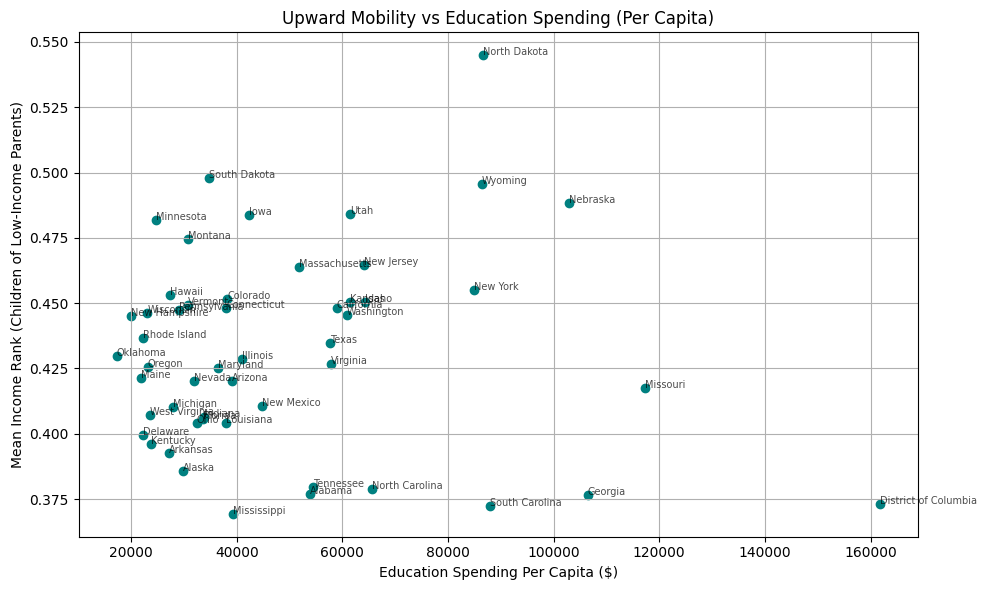

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your datasets
df_spending = pd.read_csv(directory_raw + "american_dream/per_capita_spending_by_state.csv")  # education/prison spending
df_mobility = pd.read_csv(directory_raw + "american_dream/tract_outcomes_state.csv")  # Opportunity Atlas state mobility

# --- FIPS to State Mapping (manually embedded) ---
fips_to_state = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan", 27: "Minnesota",
    28: "Mississippi", 29: "Missouri", 30: "Montana", 31: "Nebraska", 32: "Nevada",
    33: "New Hampshire", 34: "New Jersey", 35: "New Mexico", 36: "New York",
    37: "North Carolina", 38: "North Dakota", 39: "Ohio", 40: "Oklahoma", 41: "Oregon",
    42: "Pennsylvania", 44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
    47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
    53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming"
}

# Map FIPS to state name
df_mobility["State"] = df_mobility["state"].map(fips_to_state)

# Rename mobility column for clarity
df_mobility = df_mobility.rename(columns={"kfr_pooled_pooled_p25": "Upward Mobility (P25 Income Rank)"})

# Merge spending and mobility datasets
df_merged = df_spending.merge(df_mobility, on="State", how="inner")

# --- Plot: Education Spending vs Upward Mobility ---
plt.figure(figsize=(10, 6))
plt.scatter(df_merged["Education Per Capita ($)"], df_merged["Upward Mobility (P25 Income Rank)"], color='teal')
plt.title("Upward Mobility vs Education Spending (Per Capita)")
plt.xlabel("Education Spending Per Capita ($)")
plt.ylabel("Mean Income Rank (Children of Low-Income Parents)")
plt.grid(True)

# Annotate each point with the state name
for _, row in df_merged.iterrows():
    plt.annotate(row["State"], (row["Education Per Capita ($)"], row["Upward Mobility (P25 Income Rank)"]),
                 fontsize=7, alpha=0.7)

plt.tight_layout()
plt.show()


In [45]:
df_merged["Mobility Efficiency Score"] = (
    (df_merged["Upward Mobility (P25 Income Rank)"] /
    df_merged["Education Per Capita ($)"] ) * 10000
)
df_merged["State Abbr"] = df_merged["State"].apply(
    lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None
)

In [46]:
import plotly.express as px

fig = px.choropleth(
    df_merged,
    locations="State Abbr",
    locationmode="USA-states",
    color="Mobility Efficiency Score",
    color_continuous_scale="YlGnBu",
    scope="usa",
    title="Mobility Efficiency Score by State (Mobility per $10k Education Spending)",
    labels={"Mobility Efficiency Score": "Mobility / $"}
)
fig.show()


In [48]:
import pandas as pd
import plotly.express as px
import us  # pip install us if needed

# Load data
df_spending = pd.read_csv(directory_raw + "american_dream/per_capita_spending_by_state.csv")
df_mobility = pd.read_csv(directory_raw + "american_dream/tract_outcomes_state.csv")

# FIPS to state mapping
fips_to_state = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District of Columbia",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan", 27: "Minnesota",
    28: "Mississippi", 29: "Missouri", 30: "Montana", 31: "Nebraska", 32: "Nevada",
    33: "New Hampshire", 34: "New Jersey", 35: "New Mexico", 36: "New York",
    37: "North Carolina", 38: "North Dakota", 39: "Ohio", 40: "Oklahoma", 41: "Oregon",
    42: "Pennsylvania", 44: "Rhode Island", 45: "South Carolina", 46: "South Dakota",
    47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
    53: "Washington", 54: "West Virginia", 55: "Wisconsin", 56: "Wyoming"
}
df_mobility["State"] = df_mobility["state"].map(fips_to_state)
df_mobility = df_mobility.rename(columns={"kfr_pooled_pooled_p25": "Upward Mobility (P25 Income Rank)"})

# Merge both datasets
df_merged = df_spending.merge(df_mobility, on="State", how="inner")

# Add state abbreviations for plotting
df_merged["State Abbr"] = df_merged["State"].map(lambda x: us.states.lookup(x).abbr if us.states.lookup(x) else None)

# Plot heatmap by upward mobility rank
fig = px.choropleth(
    df_merged,
    locations="State Abbr",
    locationmode="USA-states",
    color="Upward Mobility (P25 Income Rank)",
    scope="usa",
    color_continuous_scale="Purples",
    title="Upward Mobility of Children from Low-Income Families by State"
)
fig.show()


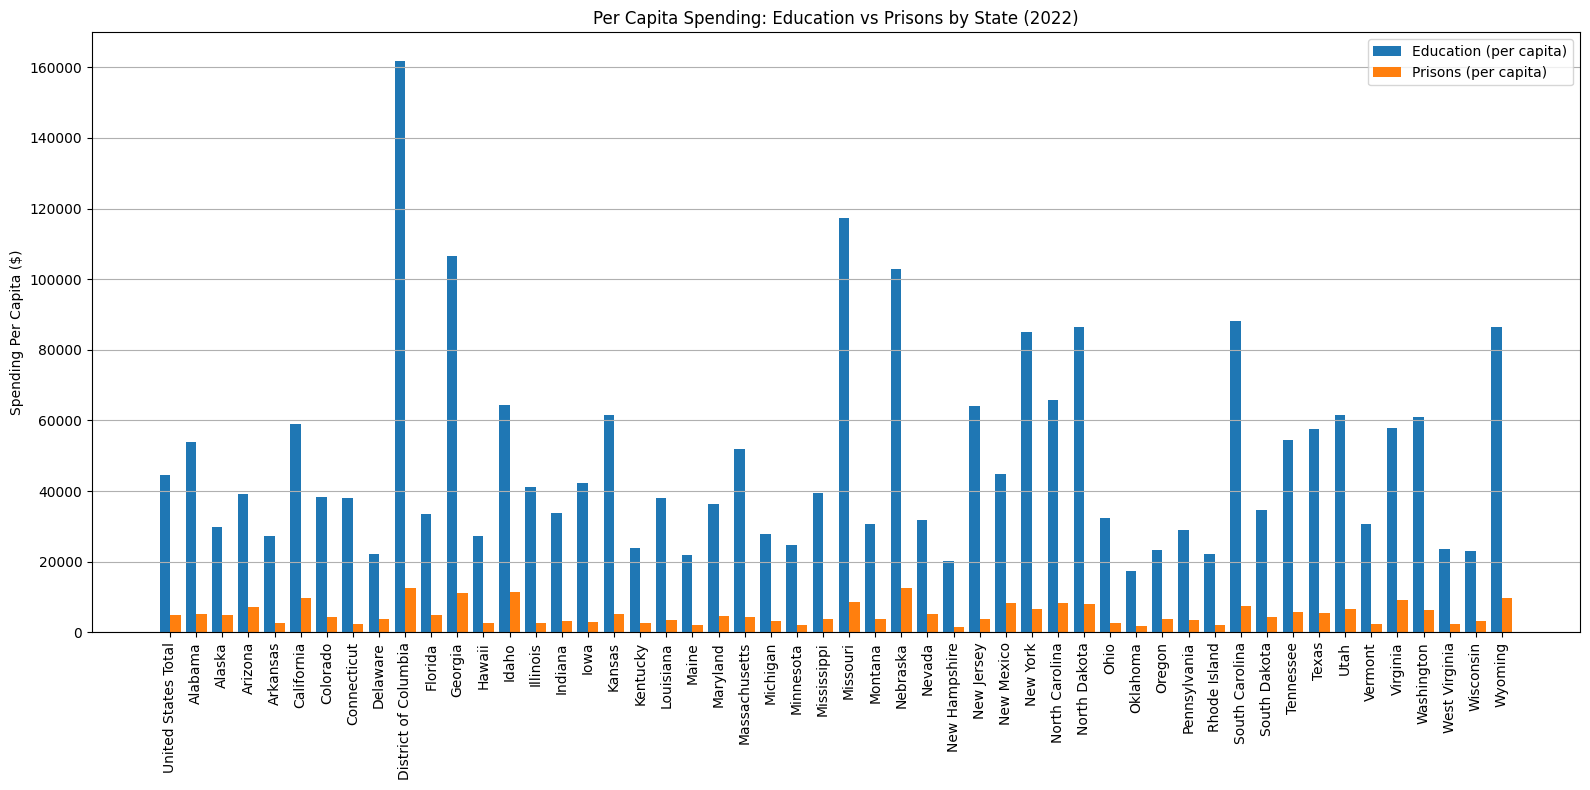

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
excel_path = "american_dream/22slsstab1.xlsx"  # Replace with full path if needed
xls = pd.ExcelFile(directory_raw + excel_path)
# Step 1: Load row 9 only (actual state names row)
df_headers = pd.read_excel(xls, sheet_name="2022_US_WY", nrows=9)
state_row = df_headers.iloc[7]  # Row with real state names

# Extract state names from every 5th column starting at index 2
raw_state_names = state_row[2:].values[::5]
state_names = [s for s in raw_state_names if isinstance(s, str)]

# Step 2: Load the actual data starting from row 10
df = pd.read_excel(xls, sheet_name="2022_US_WY", skiprows=10)

# === Helper to Extract Every 5th Column for Each State ===
def extract_row_values(df, row_index, start_col=2, step=5, state_count=None):
    row = df.iloc[row_index]
    values = row[start_col::step].astype(float).values
    return values[:state_count] if state_count else values

# === Define Row Indexes ===
ROW_EDU = 88      # "Elementary & secondary"
ROW_PRISON = 112  # "Correction"
ROW_POP = 20      # Population

# === Extract and Normalize ===
edu_spending = extract_row_values(df, ROW_EDU, state_count=len(state_names))
prison_spending = extract_row_values(df, ROW_PRISON, state_count=len(state_names))
populations = extract_row_values(df, ROW_POP, state_count=len(state_names))

edu_per_capita = [(e * 1000) / p for e, p in zip(edu_spending, populations)]
prison_per_capita = [(c * 1000) / p for c, p in zip(prison_spending, populations)]

# === Create Final Clean DataFrame ===
df_states = pd.DataFrame({
    "State": state_names,
    "Education Per Capita ($)": edu_per_capita,
    "Prison Per Capita ($)": prison_per_capita
})

# Optional: Save to CSV
df_states.to_csv("per_capita_spending_by_state.csv", index=False)

# === Plot ===
x = range(len(state_names))
bar_width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x, edu_per_capita, width=bar_width, label="Education (per capita)")
plt.bar([i + bar_width for i in x], prison_per_capita, width=bar_width, label="Prisons (per capita)")

plt.xticks([i + bar_width / 2 for i in x], state_names, rotation=90)
plt.ylabel("Spending Per Capita ($)")
plt.title("Per Capita Spending: Education vs Prisons by State (2022)")
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

In [51]:
df_states["Total Per Capita ($)"] = df_states["Education Per Capita ($)"] + df_states["Prison Per Capita ($)"]
df_states["Education % of Total"] = (df_states["Education Per Capita ($)"] / df_states["Total Per Capita ($)"]) * 100


In [52]:
import us  # pip install us if needed

df_states["State Abbr"] = df_states["State"].map(lambda name: us.states.lookup(name).abbr if us.states.lookup(name) else None)


In [53]:
import plotly.express as px

fig = px.choropleth(
    df_states,
    locations="State Abbr",
    locationmode="USA-states",
    color="Education % of Total",
    scope="usa",
    color_continuous_scale="Viridis",
    labels={"Education % of Total": "% to Education"},
    title="Percentage of Per Capita Spending Allocated to Education vs Prison (2022)"
)

fig.show()


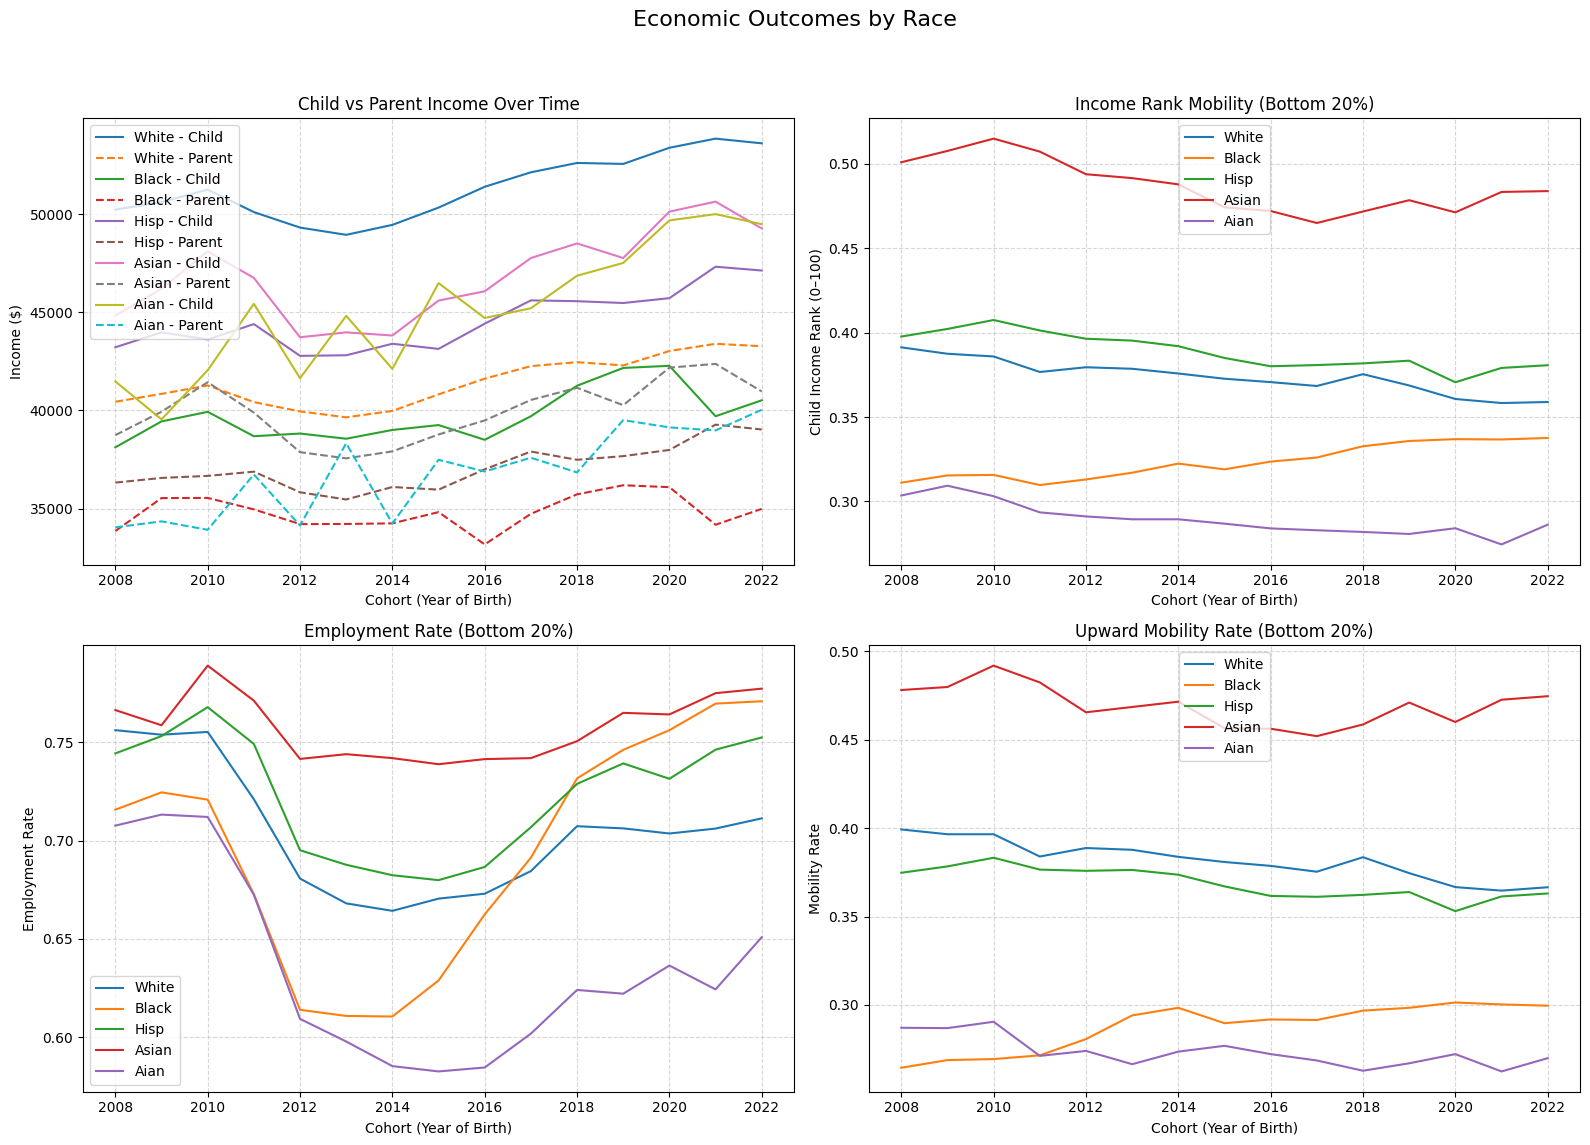

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
races = ["white", "black", "hisp", "asian", "aian"]
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Economic Outcomes by Race", fontsize=16)

# Plot 1: Child vs Parent Income
ax = axs[0, 0]
for race in races:
    ax.plot(income_demographics["cohort"], income_demographics[f"kfi_{race}_pooled_p100"], label=f"{race.capitalize()} - Child")
    ax.plot(income_demographics["cohort"], income_demographics[f"kii_{race}_pooled_p100"], linestyle="--", label=f"{race.capitalize()} - Parent")
ax.set_title("Child vs Parent Income Over Time")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Income ($)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# Plot 2: Income Rank Mobility
ax = axs[0, 1]
for race in races:
    ax.plot(income_demographics["cohort"], income_demographics[f"kir_{race}_pooled_p1"], label=race.capitalize())
ax.set_title("Income Rank Mobility (Bottom 20%)")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Child Income Rank (0–100)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# Plot 3: Employment Rate
ax = axs[1, 0]
for race in races:
    ax.plot(income_demographics["cohort"], income_demographics[f"emp_{race}_pooled_p1"], label=race.capitalize())
ax.set_title("Employment Rate (Bottom 20%)")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Employment Rate")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

# Plot 4: Upward Mobility Rate
ax = axs[1, 1]
for race in races:
    ax.plot(income_demographics["cohort"], income_demographics[f"kfr_{race}_pooled_p1"], label=race.capitalize())
ax.set_title("Upward Mobility Rate (Bottom 20%)")
ax.set_xlabel("Cohort (Year of Birth)")
ax.set_ylabel("Mobility Rate")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [37]:
races = ["white", "black", "hisp", "asian", "aian"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
fig = go.Figure()

for i, race in enumerate(races):
    fig.add_trace(go.Scatter(
        x=income_demographics["cohort"],
        y=income_demographics[f"kfi_{race}_pooled_p100"],
        name=f"{race.capitalize()} - Child",
        mode="lines",
        line=dict(color=colors[i], width=3)
    ))
    fig.add_trace(go.Scatter(
        x=income_demographics["cohort"],
        y=income_demographics[f"kii_{race}_pooled_p100"],
        name=f"{race.capitalize()} - Parent",
        mode="lines",
        line=dict(color=colors[i], width=3, dash="dash")
    ))

fig.update_layout(
    title="<b>Child vs Parent Income Over Time</b>",
    xaxis_title="Cohort (Year of Birth)",
    yaxis_title="Income ($)",
    template="plotly_white",
    font=dict(size=14),
    legend=dict(orientation="h", yanchor="bottom", y=-0.70, xanchor="center", x=0.5)
)

In [30]:
races = ["white", "black", "hisp", "asian", "aian"]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
fig = go.Figure()

for i, race in enumerate(races):
    fig.add_trace(go.Scatter(
        x=income_demographics["cohort"],
        y=income_demographics[f"emp_{race}_pooled_p1"],
        name=race.capitalize(),
        mode="lines",
        line=dict(color=colors[i], width=3)
    ))

fig.update_layout(
    title="<b>Employment Rate (Bottom 20%)</b>",
    xaxis_title="Cohort (Year of Birth)",
    yaxis_title="Employment Rate",
    template="plotly_white",
    font=dict(size=14),
    legend=dict(orientation="h", yanchor="bottom", y=-0.25, xanchor="center", x=0.5)
)

In [7]:
# Keep only students who attended college
df = df.filter(pl.col("super_opeid") > 0)

# Optional: Focus on a particular cohort (say 1985)
df_1985 = df.filter(pl.col("cohort") == 1985)

# Rename key columns for easy reference
df = df.rename({
    "mr_kq5_pq1": "mobility_rate",
    "mr_ktop1_pq1": "upper_tail_mobility",
    "par_mean": "parent_mean_income",
    "k_mean": "kid_mean_income",
})

# Drop rows with missing values in key columns
df = df.drop_nulls(["mobility_rate", "parent_mean_income", "kid_mean_income"])


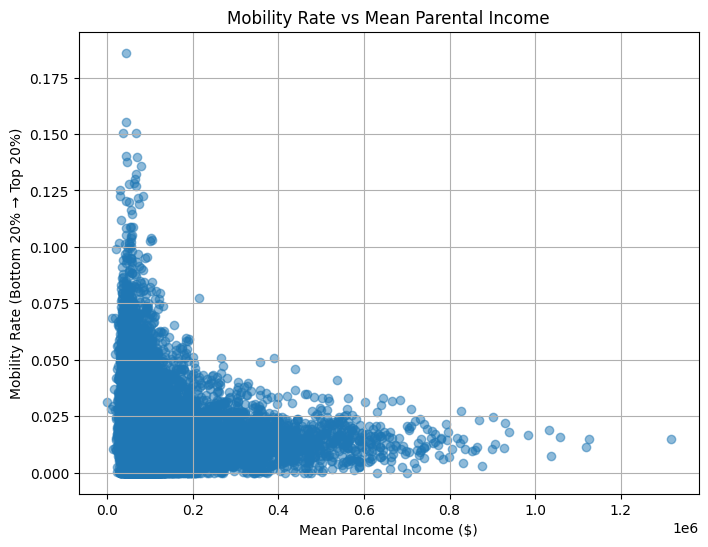

In [8]:
import matplotlib.pyplot as plt

df_pd = df.to_pandas()

plt.figure(figsize=(8,6))
plt.scatter(df_pd["parent_mean_income"], df_pd["mobility_rate"], alpha=0.5)
plt.title("Mobility Rate vs Mean Parental Income")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True)
plt.show()


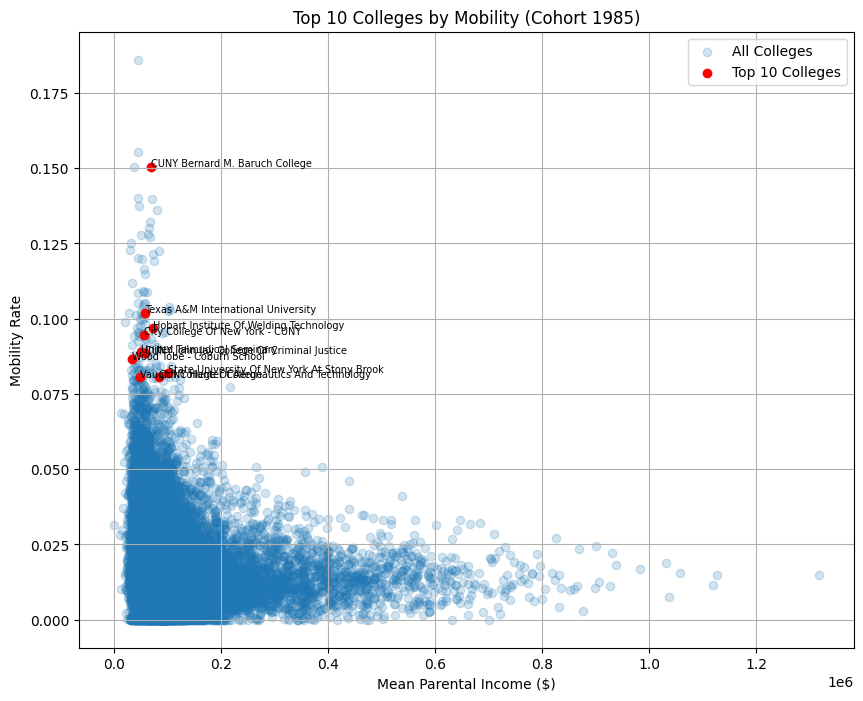

In [16]:
# Top 10 mobility colleges
top10 = df_1985.sort("mobility_rate", descending=True).head(10).to_pandas()

plt.figure(figsize=(10,8))
plt.scatter(df_pd["parent_mean_income"], df_pd["mobility_rate"], alpha=0.2, label="All Colleges")
plt.scatter(top10["parent_mean_income"], top10["mobility_rate"], color='red', label="Top 10 Colleges")

# Annotate
for idx, row in top10.iterrows():
    plt.text(row["parent_mean_income"], row["mobility_rate"], row["name"], fontsize=7)

plt.title("Top 10 Colleges by Mobility (Cohort 1985)")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate")
plt.legend()
plt.grid(True)
plt.show()


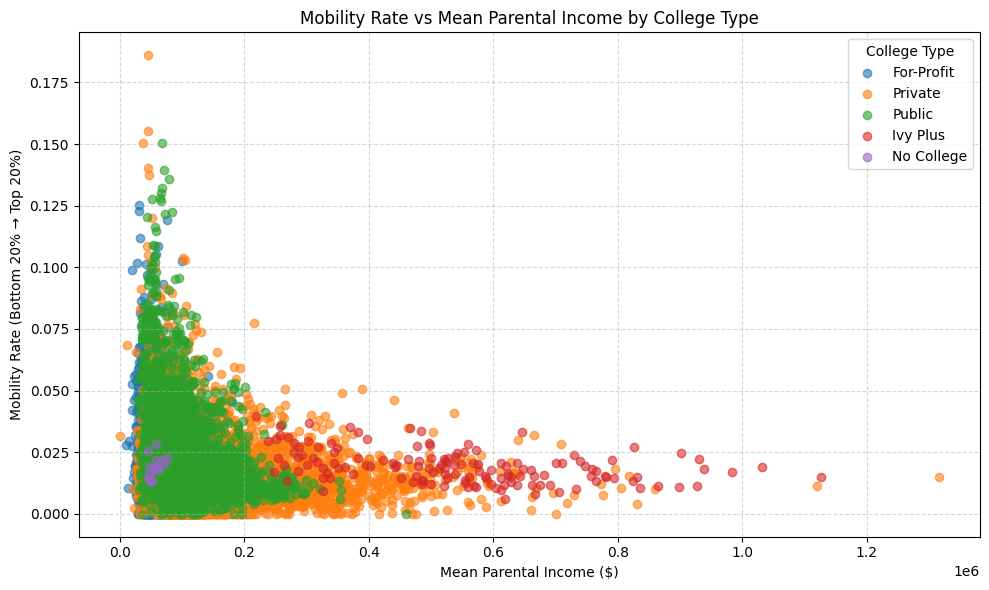

In [48]:
import polars as pl
import matplotlib.pyplot as plt

# STEP 1: Load CSV data
df = read_data("mrc_table3.csv")  # Make sure your file is in the same directory

df = df.with_columns(
    pl.when(pl.col("tier") == 1).then(pl.lit("Ivy Plus"))
    .when(pl.col("tier").is_in([3, 5, 7])).then(pl.lit("Public"))
    .when(pl.col("tier").is_in([4, 6, 8])).then(pl.lit("Private"))
    .when(pl.col("tier").is_in([10, 11])).then(pl.lit("For-Profit"))
    .when(pl.col("tier").is_in([13, 14])).then(pl.lit("No College"))
    .otherwise(pl.lit(None))
    .alias("college_type")
)

# Filter rows with assigned types
df_filtered = df.filter(pl.col("college_type").is_not_null())

# Convert to pandas for plotting
df_pd = df_filtered.select(["par_mean", "mr_kq5_pq1", "college_type"]).to_pandas()

# Scatter plot by college type
plt.figure(figsize=(10, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["par_mean"], sub_df["mr_kq5_pq1"], label=ctype, alpha=0.6)

plt.title("Mobility Rate vs Mean Parental Income by College Type")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()

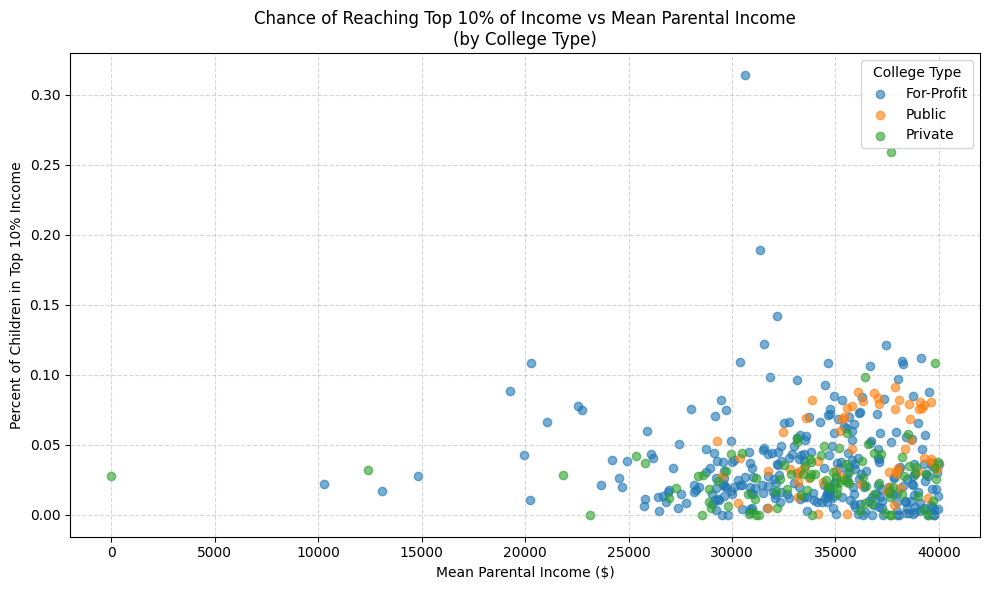

In [34]:
import polars as pl
import matplotlib.pyplot as plt

# STEP 1: Load the dataset
df = read_data("mrc_table3.csv")

# STEP 2: Filter for low parental income (< $40,000), optional
df = df.filter(pl.col("par_mean") < 40000)

# STEP 3: Assign college types using 'tier'
df = df.with_columns(
    pl.when(pl.col("tier") == 1).then(pl.lit("Ivy League"))
     .when(pl.col("tier").is_in([3, 5, 7])).then(pl.lit("Public"))
     .when(pl.col("tier").is_in([4, 6, 8])).then(pl.lit("Private"))
     .when(pl.col("tier").is_in([10, 11])).then(pl.lit("For-Profit"))
     .otherwise(pl.lit(None))
     .alias("college_type")
)

# STEP 4: Filter out rows without a college_type or k_top10pc
df_filtered = df.filter(
    (pl.col("college_type").is_not_null()) &
    (pl.col("k_top10pc").is_not_null())
)

# STEP 5: Convert to pandas for plotting
df_pd = df_filtered.select(["par_mean", "k_top10pc", "college_type"]).to_pandas()

# STEP 6: Plot
plt.figure(figsize=(10, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["par_mean"], sub_df["k_top10pc"], label=ctype, alpha=0.6)

plt.title("Chance of Reaching Top 10% of Income vs Mean Parental Income\n(by College Type)")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Percent of Children in Top 10% Income")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()
plt.show()


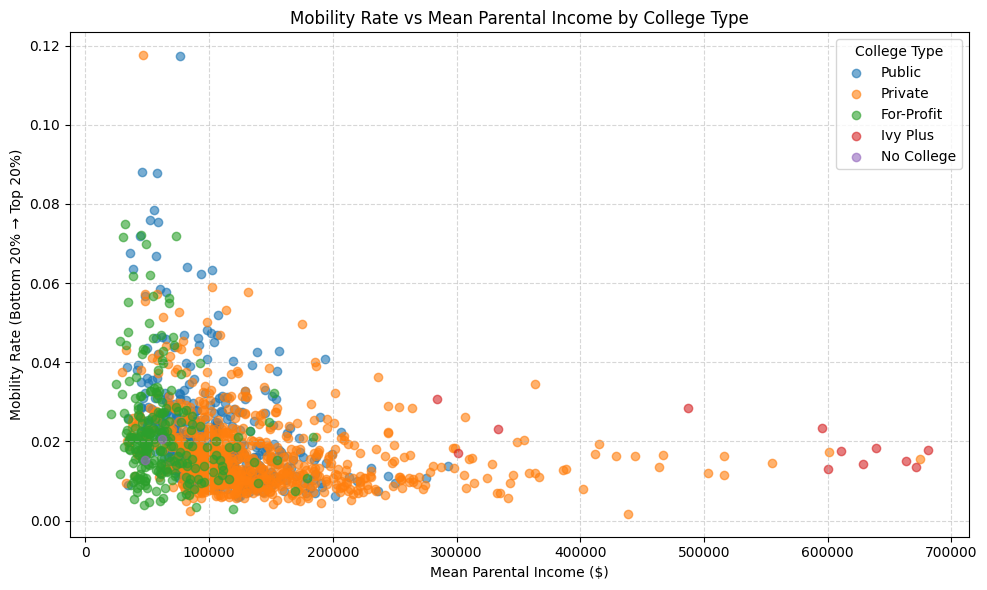

In [ ]:
child_income = read_data(folder='economy', file_name="mrc_table3.csv")

df = child_income.with_columns(
    pl.when(pl.col("tier") == 1).then(pl.lit("Ivy Plus"))
    .when(pl.col("tier").is_in([3, 5, 7])).then(pl.lit("Public"))
    .when(pl.col("tier").is_in([4, 6, 8])).then(pl.lit("Private"))
    .when(pl.col("tier").is_in([10, 11])).then(pl.lit("For-Profit"))
    .when(pl.col("tier").is_in([13, 14])).then(pl.lit("No College"))
    .otherwise(pl.lit(None))
    .alias("college_type")
)

# Filter rows with assigned types
df_filtered = (
    df
    .group_by("name")
    .agg(pl.mean("par_mean").alias("par_mean"), pl.mean("mr_kq5_pq1").alias("mr_kq5_pq1"), pl.first("college_type").alias("college_type"))
    .filter(pl.col("college_type").is_not_null())
    )


# Convert to pandas for plotting
df_pd = df_filtered.select(["par_mean", "mr_kq5_pq1", "college_type"]).to_pandas()

# Scatter plot by college type
plt.figure(figsize=(10, 6))
for ctype in df_pd["college_type"].unique():
    sub_df = df_pd[df_pd["college_type"] == ctype]
    plt.scatter(sub_df["par_mean"], sub_df["mr_kq5_pq1"], label=ctype, alpha=0.6)

plt.title("Mobility Rate vs Mean Parental Income by College Type")
plt.xlabel("Mean Parental Income ($)")
plt.ylabel("Mobility Rate (Bottom 20% → Top 20%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="College Type")
plt.tight_layout()

In [ ]:
import pandas as pd
import numpy as np

# Load the Excel file
excel_path = "american_dream/22slsstab1.xlsx"  # Located in data_raw/
directory_raw = str(Path.cwd().parent) + '/data_raw/'
xls = pd.ExcelFile(directory_raw + excel_path)

# Step 1: Load state names from header row
header_df = pd.read_excel(xls, sheet_name=xls.sheet_names[0], nrows=9)
state_row = header_df.iloc[7]
state_names = [s for s in state_row[2:].values[::5] if isinstance(s, str)]
state_names

# Step 2: Load actual data starting from row 10
raw_df = pd.read_excel(xls, sheet_name=xls.sheet_names[0], skiprows=10)
raw_df
# Helper to extract every 5th column for each state
def extract_row_values(df, row_index, start_col=2, step=5, state_count=None):
    row = df.iloc[row_index]
    values = row[start_col::step].astype(float).values
    return values[:state_count] if state_count else values

# Row indexes for spending categories
ROW_TOTAL = 71     # "Total Direct General Expenditure"
ROW_ENTITLEMENT = 96  # "Public Welfare" (Entitlement spending)
ROW_POP = 20        # Population

# Extract and normalize
state_count = len(state_names)
total_spending = extract_row_values(raw_df, ROW_TOTAL, state_count=state_count)
total_spending
entitlement_spending = extract_row_values(raw_df, ROW_ENTITLEMENT, state_count=state_count)
entitlement_spending
# populations = extract_row_values(raw_df, ROW_POP, state_count=state_count)
# per_capita_total = [(t * 1000) / p for t, p in zip(total_spending, populations)]
# per_capita_entitlement = [(e * 1000) / p for e, p in zip(entitlement_spending, populations)]

# # Create DataFrame
# spending_df = pd.DataFrame({
#     "State": state_names,
#     "Total Spend Per Capita ($)": per_capita_total,
#     "Entitlement Spend Per Capita ($)": per_capita_entitlement
# })

# spending_df.head()

array([4.28845528e+08, 5.72800600e+06, 2.11079100e+06, 7.58587000e+06,
       3.22612900e+06, 5.57455330e+07, 1.19045310e+07, 4.04837300e+06,
       1.26593900e+06, 2.95925600e+06, 2.46692670e+07, 1.06290870e+07,
       2.41085200e+06, 1.81451900e+06, 1.48911790e+07, 7.53237100e+06,
       4.85598800e+06, 3.36560500e+06, 5.23170600e+06, 5.46804700e+06,
       1.12776000e+06, 7.90655800e+06, 1.02758230e+07, 9.11123400e+06,
       8.29191200e+06, 2.63092200e+06, 5.91302900e+06, 1.26648300e+06,
       4.44883800e+06, 3.66684700e+06, 8.85504000e+05, 7.77788200e+06,
       2.68385900e+06, 2.98372960e+07, 1.25710220e+07, 1.93219800e+06,
       1.17616070e+07, 5.36017900e+06, 6.70129800e+06, 1.69132740e+07,
       1.11350000e+06, 5.55977200e+06, 1.45376700e+06, 6.86121000e+06,
       4.42144710e+07, 6.15642100e+06, 6.07698000e+05, 1.23546870e+07,
       1.40715010e+07, 1.89264400e+06, 6.80543000e+06, 1.24785300e+06])

In [64]:
# Inspect raw extracted values for total and entitlement spending
print("State Names:", state_names)
print("Raw Total Spending (first 10):", total_spending[:10])

# Uncomment and run for entitlement spending
# entitlement_spending = extract_row_values(raw_df, ROW_ENTITLEMENT, state_count=state_count)
# print("Raw Entitlement Spending (first 10):", entitlement_spending[:10])

# Check for zeros and NaNs
print("Total Spending Zeros:", np.sum(np.array(total_spending) == 0))
# print("Entitlement Spending Zeros:", np.sum(np.array(entitlement_spending) == 0))

State Names: ['United States Total', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
Raw Total Spending (first 10): [7.639609e+06 4.594620e+05 2.094600e+04 6.178200e+04 1.786000e+03
 3.988080e+05 2.663850e+05 2.132000e+04 0.000000e+00 0.000000e+00]
Total Spending Zeros: 12


In [69]:
# Inspect column headers and first few rows to check for population column
print("Column headers:", raw_df.columns.tolist())
print(raw_df.head(10))

Column headers: ['Unnamed: 0', 'Unnamed: 1', 'government', 'government.1', 'government.2', 'government.3', 'government.4', 'government.5', 'government.6', 'government.7', 'government.8', 'government.9', 'government.10', 'government.11', 'government.12', 'government.13', 'government.14', 'government.15', 'government.16', 'government.17', 'government.18', 'government.19', 'government.20', 'government.21', 'government.22', 'government.23', 'government.24', 'government.25', 'government.26', 'government.27', 'government.28', 'government.29', 'government.30', 'government.31', 'government.32', 'government.33', 'government.34', 'government.35', 'government.36', 'government.37', 'government.38', 'government.39', 'government.40', 'government.41', 'government.42', 'government.43', 'government.44', 'government.45', 'government.46', 'government.47', 'government.48', 'government.49', 'government.50', 'government.51', 'government.52', 'government.53', 'government.54', 'government.55', 'government.56'

In [70]:
# --- Merge External Population Data and Finish Analysis ---
import pandas as pd

# Load state-level population data (latest year available)
pop_df = pd.read_csv('../data/economy/population.csv')
latest_year = pop_df['year'].max()
pop_latest = pop_df[pop_df['year'] == latest_year].copy()

# Prepare state names for merge (assume state_names from previous cells)
# If state_names is not available, you may need to reload or extract it again
state_names = [s for s in state_row[2:].values[::5] if isinstance(s, str)]

# Create DataFrame for state spending (from previous extraction)
spending_df = pd.DataFrame({
    'State': state_names,
    'Total Spend ($1000s)': total_spending,
    'Entitlement Spend ($1000s)': entitlement_spending
})

# Merge with population data (assume US states only, not DC/territories)
# You may need a mapping from state name to population if population.csv is national only
# For demonstration, use national population for all states (adjust if you have state-level population)
spending_df['Population'] = int(pop_latest['population'].values[0])

# Calculate per capita spending
spending_df['Total Spend Per Capita ($)'] = (spending_df['Total Spend ($1000s)'] * 1000) / spending_df['Population']
spending_df['Entitlement Spend Per Capita ($)'] = (spending_df['Entitlement Spend ($1000s)'] * 1000) / spending_df['Population']

# Display summary statistics
print('Per Capita Spending by State (using national population):')
print(spending_df[['State', 'Total Spend Per Capita ($)', 'Entitlement Spend Per Capita ($)']].head())

# Optional: Save to CSV
spending_df.to_csv('per_capita_total_entitlement_spending_by_state.csv', index=False)

Per Capita Spending by State (using national population):
                 State  Total Spend Per Capita ($)  \
0  United States Total                 1280.461199   
1              Alabama                   17.102870   
2               Alaska                    6.302470   
3              Arizona                   22.650142   
4             Arkansas                    9.632683   

   Entitlement Spend Per Capita ($)  
0                        272.493011  
1                          4.585359  
2                          0.308905  
3                         11.874530  
4                          2.213709  


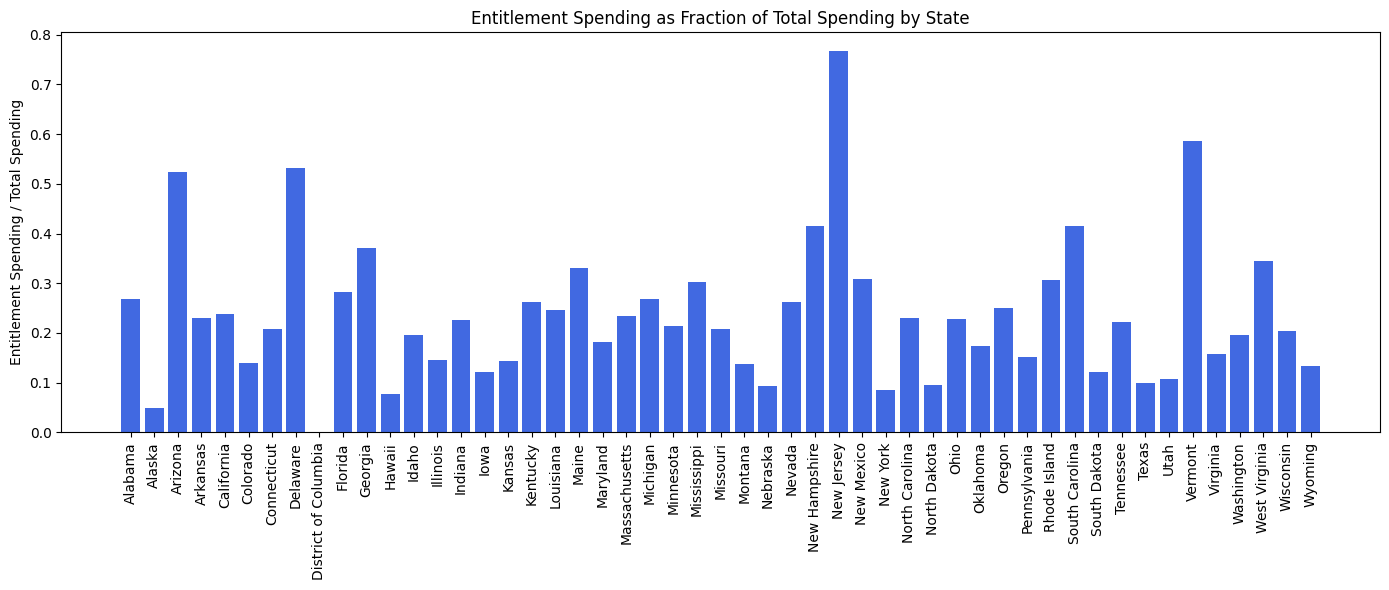

In [71]:
# --- Remove United States Total, Calculate Fraction, and Plot ---
import matplotlib.pyplot as plt

# Remove 'United States Total' if present in state list
spending_df_clean = spending_df[spending_df['State'] != 'United States Total'].copy()

# Calculate entitlement spending as a fraction of total spending
spending_df_clean['Entitlement Fraction'] = spending_df_clean['Entitlement Spend ($1000s)'] / spending_df_clean['Total Spend ($1000s)']

# Plot entitlement fraction by state
plt.figure(figsize=(14, 6))
plt.bar(spending_df_clean['State'], spending_df_clean['Entitlement Fraction'], color='royalblue')
plt.xticks(rotation=90)
plt.ylabel('Entitlement Spending / Total Spending')
plt.title('Entitlement Spending as Fraction of Total Spending by State')
plt.tight_layout()
plt.show()

In [ ]:
# --- Plot Entitlement Fraction as a Choropleth Map ---
import plotly.express as px
import us  # pip install us if needed

# Add state abbreviations for mapping
spending_df_clean['State Abbr'] = spending_df_clean['State'].map(lambda name: us.states.lookup(name).abbr if us.states.lookup(name) else None)

fig = px.choropleth(
    spending_df_clean,
    locations='State Abbr',
    locationmode='USA-states',
    color='Entitlement Fraction',
    scope='usa',
    color_continuous_scale='Oranges',
    labels={'Entitlement Fraction': 'Entitlement / Total'},
    title='Welfare Spend vs Total Spending by State'
 )

fig.show()

In [ ]:
# --- Plot Entitlement Fraction as a Choropleth Map (Orange-Red) ---
import plotly.express as px
import us  # pip install us if needed

# Add state abbreviations for mapping
spending_df_clean['State Abbr'] = spending_df_clean['State'].map(lambda name: us.states.lookup(name).abbr if us.states.lookup(name) else None)

fig = px.choropleth(
    spending_df_clean,
    locations='State Abbr',
    locationmode='USA-states',
    color='Entitlement Fraction',
    scope='usa',
    color_continuous_scale='OrRd',
    labels={'Entitlement Fraction': 'Entitlement / Total'},
    title='Entitlement Spending as Fraction of Total Spending by State'
 )

fig.show()

In [75]:
# --- Plot Entitlement Spend vs Upward Mobility as a Choropleth Map ---
import plotly.express as px
import us  # pip install us if needed

# Assume df_mobility is already loaded and contains 'State' and 'Upward Mobility (P25 Income Rank)' columns
# Merge with entitlement fraction data
mobility_map_df = spending_df_clean.merge(df_mobility[['State', 'Upward Mobility (P25 Income Rank)']], on='State', how='left')

# Add state abbreviations for mapping
mobility_map_df['State Abbr'] = mobility_map_df['State'].map(lambda name: us.states.lookup(name).abbr if us.states.lookup(name) else None)

fig = px.scatter_geo(
    mobility_map_df,
    locations='State Abbr',
    locationmode='USA-states',
    color='Entitlement Fraction',
    size='Upward Mobility (P25 Income Rank)',
    scope='usa',
    color_continuous_scale='OrRd',
    labels={'Entitlement Fraction': 'Entitlement / Total', 'Upward Mobility (P25 Income Rank)': 'Mobility'},
    title='Entitlement Spend vs Upward Mobility by State'
)

fig.show()

In [ ]:
# --- Choropleth: Upward Mobility as Color, Entitlement Fraction as Hover ---
import plotly.express as px
import us  # pip install us if needed

# Use merged DataFrame from previous cell
mobility_map_df['State Abbr'] = mobility_map_df['State'].map(lambda name: us.states.lookup(name).abbr if us.states.lookup(name) else None)

fig = px.choropleth(
    mobility_map_df,
    locations='State Abbr',
    locationmode='USA-states',
    color='Upward Mobility (P25 Income Rank)',
    scope='usa',
    color_continuous_scale='OrRd',
    hover_data={'Entitlement Fraction': True},
    labels={'Upward Mobility (P25 Income Rank)': 'Mobility'},
    title='Upward Mobility by State (Entitlement Fraction in Hover)'
)

fig.show()